# Grid Optimization Analysis

In [36]:
import matplotlib.cm
import math
import numpy as np
import qcportal as ptl
from IPython.display import display, HTML
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.offsetbox import AnnotationBbox, DrawingArea, TextArea
from sklearn import decomposition # PCA
from sklearn.cluster import AgglomerativeClustering

In [2]:
# Interactive plots
%matplotlib notebook

## Loading the Data

In [3]:
CLIENT = ptl.FractalClient()
DATASET = CLIENT.get_collection('GridOptimizationDataset',
                                'OpenFF Trivalent Nitrogen Set 1')
MOLECULE_IDS = [
    DATASET.get_entry(index).initial_molecule for index in DATASET.df.index
]
MOLECULES = CLIENT.query_molecules(id=MOLECULE_IDS)
METADATA_ENTRIES = [
    DATASET.get_entry(index).object_map['default'] for index in DATASET.df.index
]
# get all grid optimization calculations from the entire dataset
ENTRIES = CLIENT.query_procedures(METADATA_ENTRIES)

# Expected number of optimization frames
NUM_FRAMES = 21

# Remove molecules that have no optimizations
GOOD_MOLECULES = []
GOOD_ENTRIES = []
for idx, entry in enumerate(ENTRIES):
    final_energies = entry.get_final_energies()
    if len(final_energies) != NUM_FRAMES:
        print(f"Molecule {idx:3} ({MOLECULES[idx].get_molecular_formula()}) has {len(final_energies)} frames")
    else:
        GOOD_MOLECULES.append(MOLECULES[idx])
        GOOD_ENTRIES.append(ENTRIES[idx])

Molecule  66 (C22Cl2H24NO6PS) has 0 frames
Molecule  83 (C16H37NO2P2S2) has 0 frames
Molecule  84 (C22H24NO2PS) has 0 frames
Molecule  85 (C20H21N3O4S) has 0 frames
Molecule 138 (C4H6N2O) has 0 frames
Molecule 141 (C19H13NO3S) has 0 frames
Molecule 157 (C31H45N3O8S3) has 0 frames
Molecule 160 (C21H22N2O6S2) has 0 frames
Molecule 175 (C28H22NO2P) has 0 frames
Molecule 193 (C22H24N6O6S2) has 0 frames
Molecule 204 (C12H21N2P) has 0 frames
Molecule 218 (BrC9H8N3) has 0 frames
Molecule 236 (C6H5N3) has 0 frames
Molecule 242 (C13H18N3O2) has 0 frames
Molecule 252 (C24H20NOP) has 0 frames
Molecule 277 (C12H11N2O3S) has 0 frames
Molecule 279 (C10H8N2O2) has 0 frames
Molecule 286 (C7H4INO3S) has 0 frames
Molecule 298 (C22H30N3P) has 0 frames


In [4]:
print(f"There are {len(GOOD_MOLECULES)} good molecules.")

There are 292 good molecules.


## Visualization

Get a better idea of what the data looks like using PCA.

In [5]:
# Create vectors of the energies
ENERGIES = np.zeros(shape=(len(GOOD_ENTRIES), NUM_FRAMES))

for idx, entry in enumerate(GOOD_ENTRIES):
    final_energies = entry.get_final_energies()
    for frame_idx in range(NUM_FRAMES):
        ENERGIES[idx][frame_idx] = final_energies[(frame_idx,)]
    # Normalize the energies by subtracting the minimum energy
    min_energy = np.min(ENERGIES[idx])
    ENERGIES[idx] -= min_energy

# Apply PCA to reduce to 2d for plotting
pca_2d = decomposition.PCA(n_components=2)
ENERGIES_2D = pca_2d.fit_transform(ENERGIES)

In [83]:
def plot_1d_scan(ax, index):
    """Plots a 1D scan of the given molecule on the given axis"""
    ax.plot(np.arange(0,NUM_FRAMES,1), ENERGIES[index])
    ax.set_title(f"Molecule {index} | {GOOD_MOLECULES[index].get_molecular_formula()}")
    ax.set_xticks(np.arange(0,NUM_FRAMES,2))

def pca_plot(cluster_ids=None):
    """Create a plot of the PCA.
    
    When one hovers over the points, they can see the normalized 1D
    scan for it, as well as the index and molecular formula.
    |cluster_ids| is an array such that cluster_ids[i] is the cluster id
    of molcule i.
    """
    %matplotlib notebook
    
    if cluster_ids is None:
        cluster_ids = np.zeros(len(GOOD_ENTRIES))
    fig, ax = plt.subplots(1,2,figsize=(10, 4))
    pca_ax = ax[0]  # Scatterplot of the energies after 2D PCA
    scan_ax = ax[1] # 1D scan of molecule energies
    
    scatter_path = pca_ax.scatter(ENERGIES_2D[:,0],
                                  ENERGIES_2D[:,1],
                                  c=cluster_ids,
                                  cmap=matplotlib.cm.get_cmap("tab20c"))
    pca_ax.set_title("2D PCA of Grid Optimization Energies")

    def show_plot(event):
        """
        A callback that handles mouse events and shows the molecule
        in the plot.
        """
        mouse_hovering, info = scatter_path.contains(event)
        if mouse_hovering:
            # Index within the scatter plot points where the mouse hovers.
            index, = info["ind"]
            # Set the 1D scan plot to correspond to the point.
            scan_ax.clear()
            plot_1d_scan(scan_ax, index)
        fig.canvas.draw_idle()
    # Add the callback.
    fig.canvas.mpl_connect('motion_notify_event', show_plot)

    plt.show()

<IPython.core.display.Javascript object>


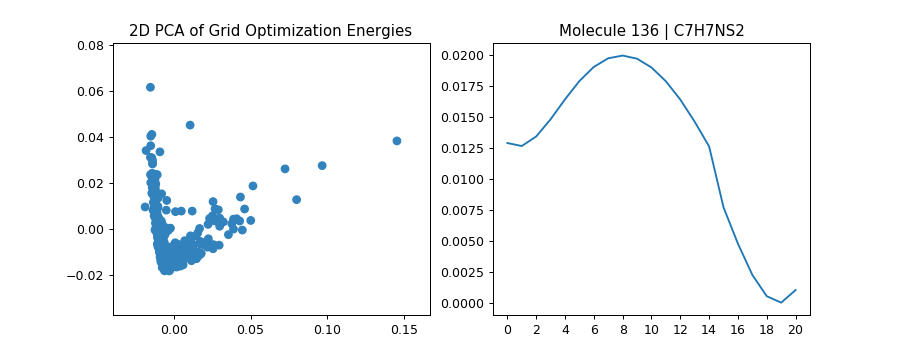

In [84]:
# Rerun if interactivity not working
pca_plot()

## Clustering
Clustering the molecules by energy profile.

In [89]:
def cluster_ids_to_clusters(cluster_ids):
    """Get a list where entry i lists the molecules in cluster i."""
    num_clusters = len(set(cluster_ids))
    clusters = [[] for _ in range(num_clusters)]
    for mol_idx,cid in enumerate(cluster_ids):
        clusters[cid].append(mol_idx)
    return clusters

def get_clusters(n_clusters=10):
    """Get the ids and clusters from clustering with n clusters.
    
    Indices correspond to molecules in GOOD_ENTRIES.
    """
    # Tells the cluster id of every molecule in GOOD_ENTRIES
    cluster_ids = AgglomerativeClustering(n_clusters=n_clusters,
                                          affinity="euclidean",
                                          linkage="ward").fit_predict(ENERGIES)
    return cluster_ids, cluster_ids_to_clusters(cluster_ids)

def plot_details_for_clusters(clusters):
    """Plot the 1D scans and other details of molecules in each cluster."""
    COLS = 4
    FIG_WIDTH = 13
    PLOT_HEIGHT = 3
    %matplotlib inline

    for cid,cluster in enumerate(clusters):
        display(HTML(f"<h1>Cluster {cid}</h1>"))
        rows = math.ceil(len(clusters[cid]) / COLS)
        fig, ax = plt.subplots(rows, COLS, figsize=(FIG_WIDTH, PLOT_HEIGHT * rows))
        fig.tight_layout() # Improve spacing between plots
        ax = np.atleast_2d(ax)

        idx = 0
        for r in range(rows):
            for c in range(COLS):
                if idx < len(cluster):
                    plot_1d_scan(ax[r,c], cluster[idx])
                idx += 1
        plt.show()

In [90]:
cluster_ids, clusters = get_clusters(15) # Modify number of clusters as needed

<IPython.core.display.Javascript object>


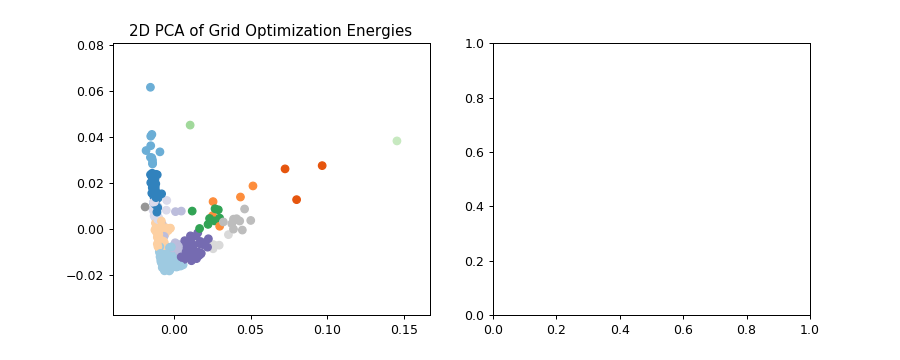

In [91]:
pca_plot(cluster_ids)

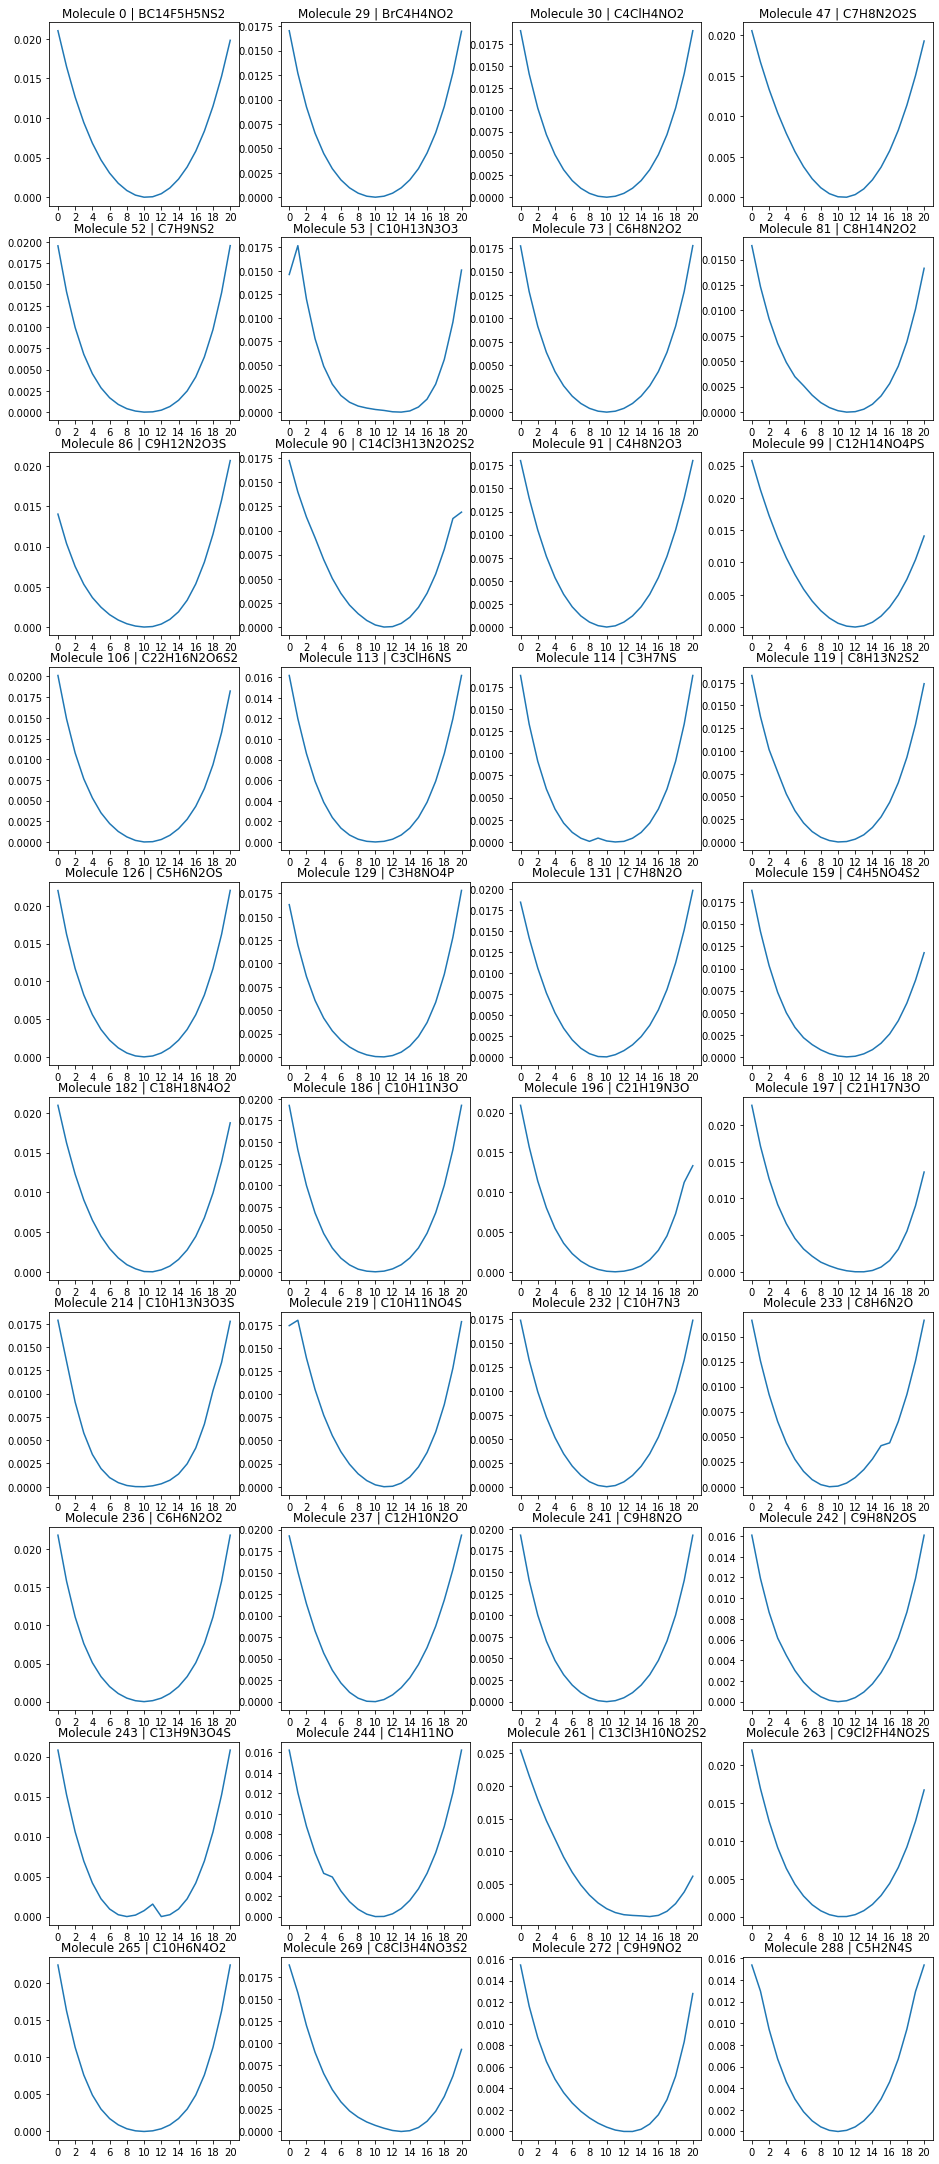

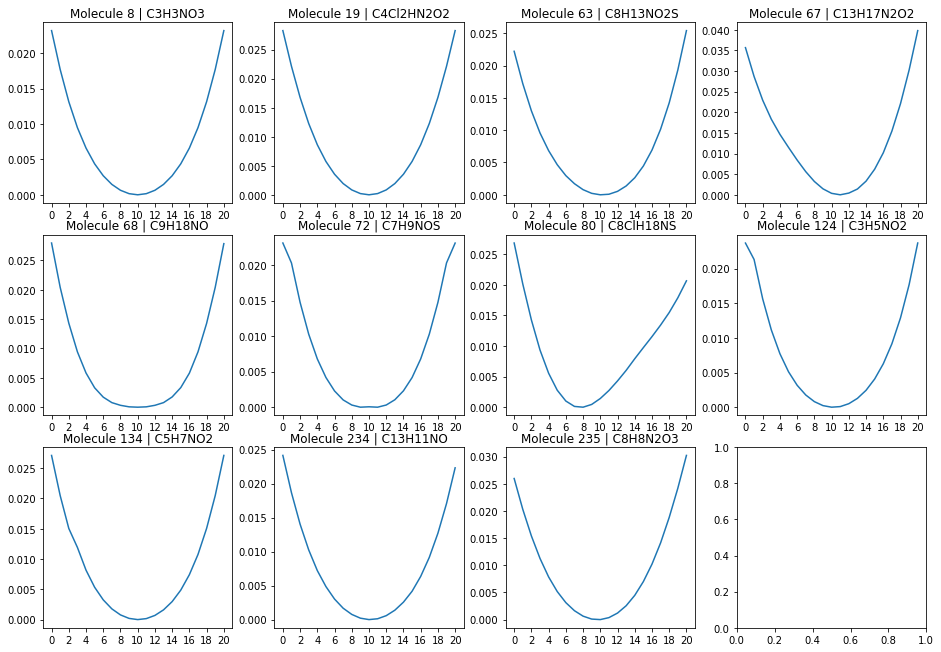

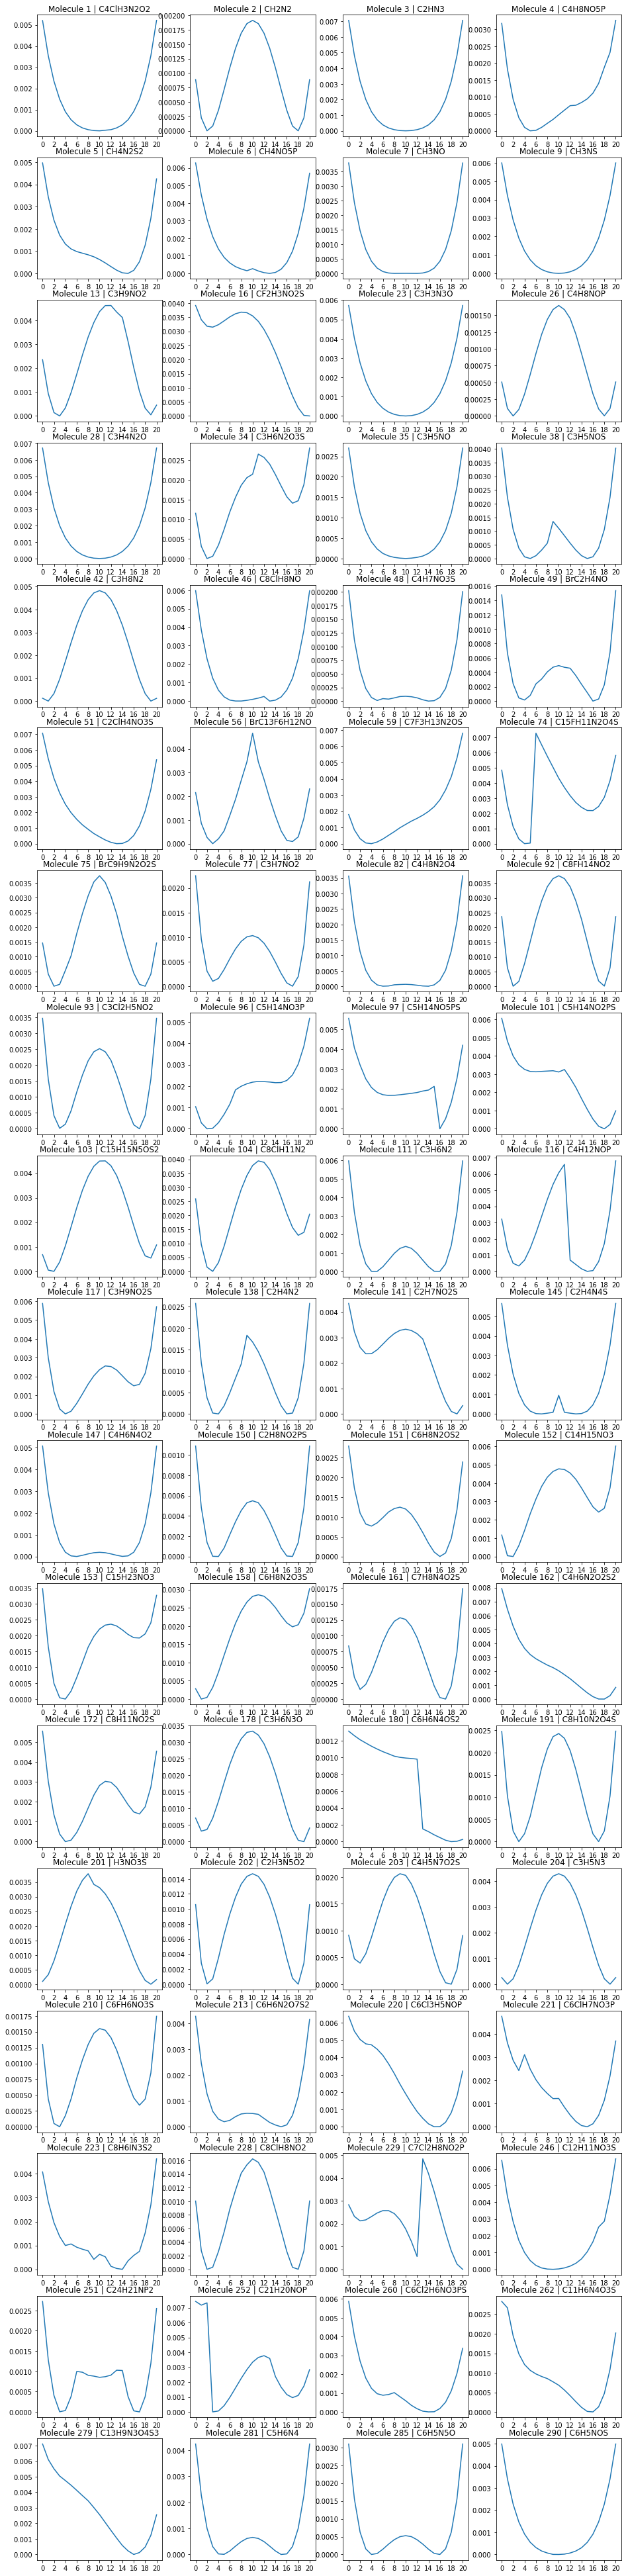

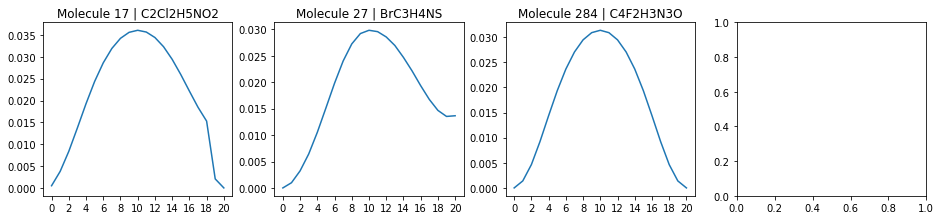

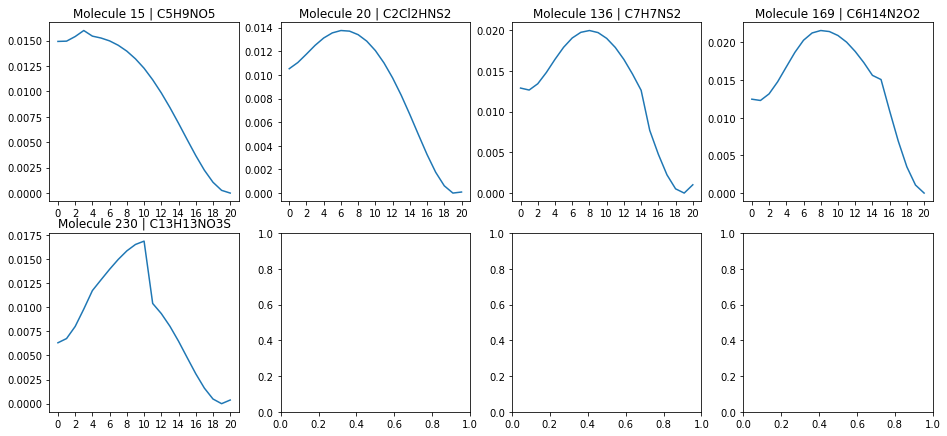

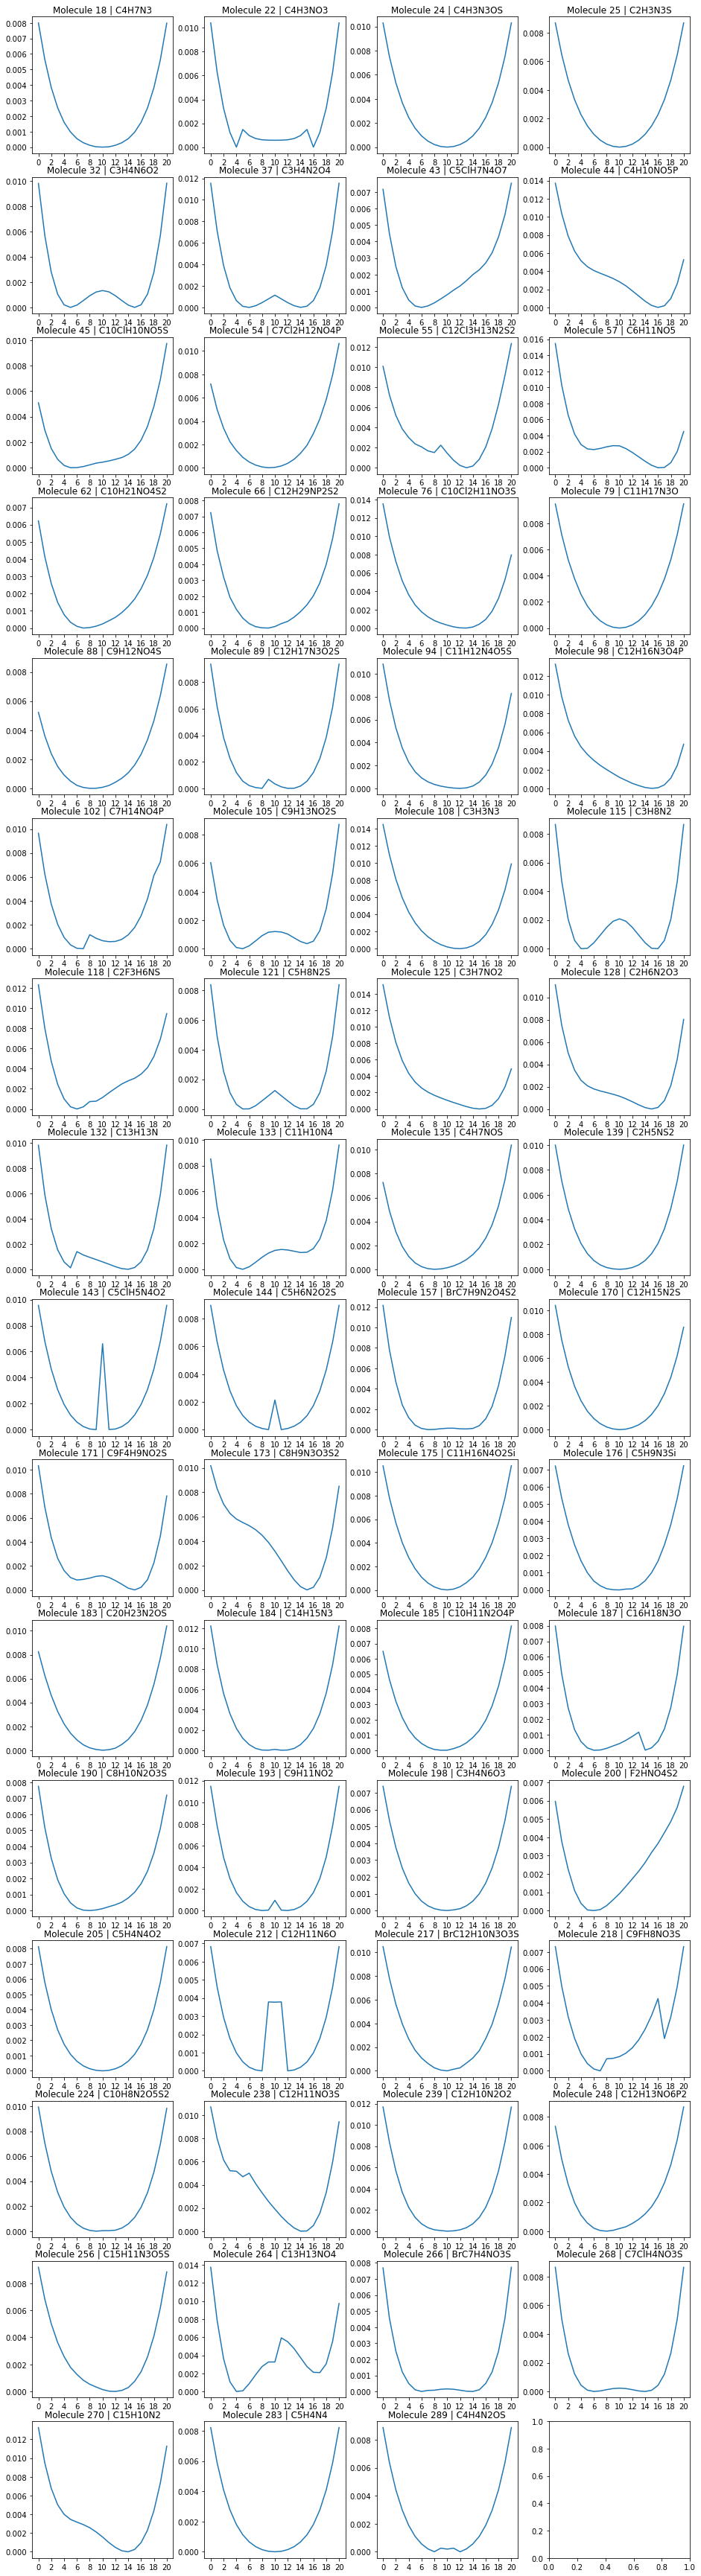

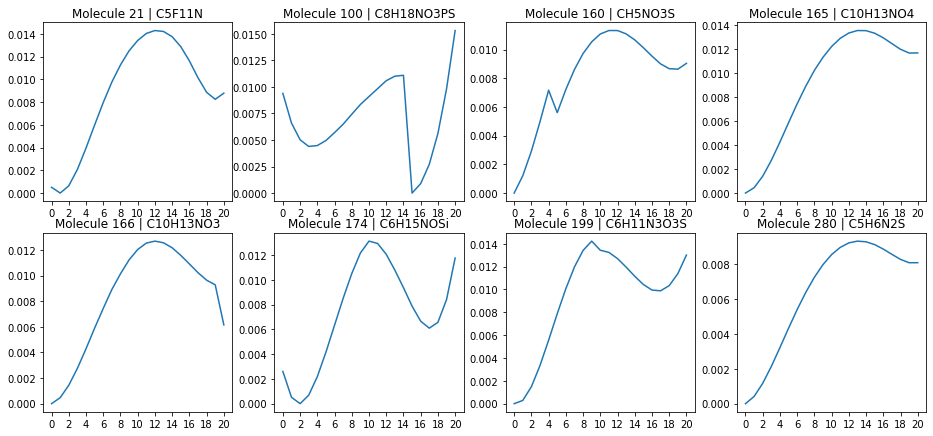

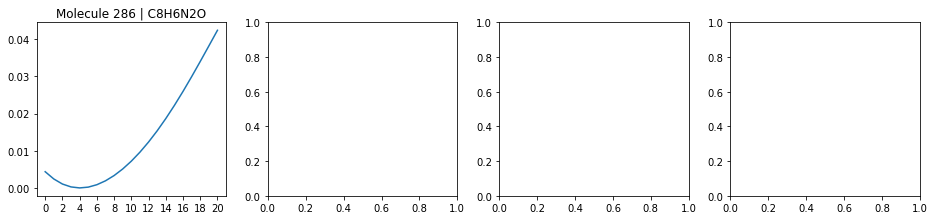

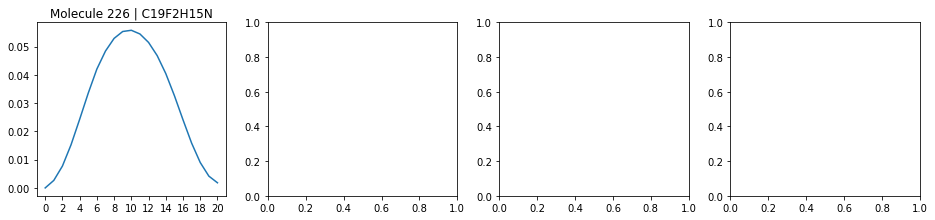

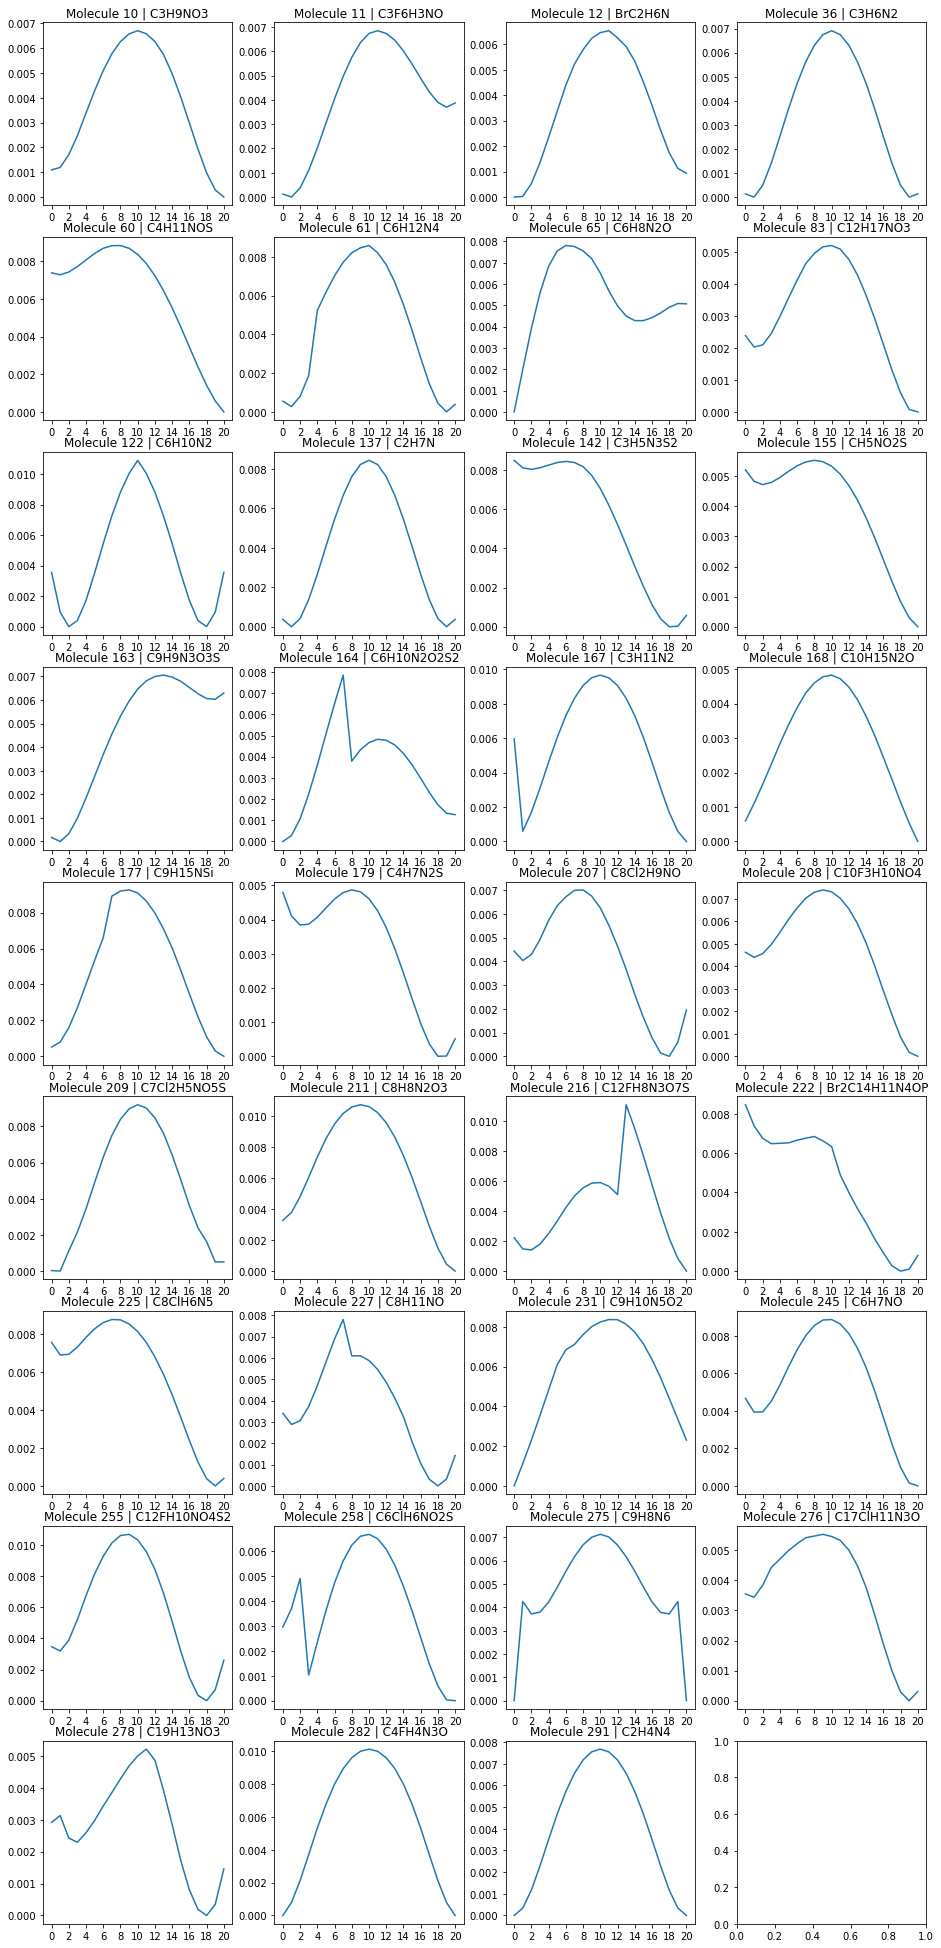

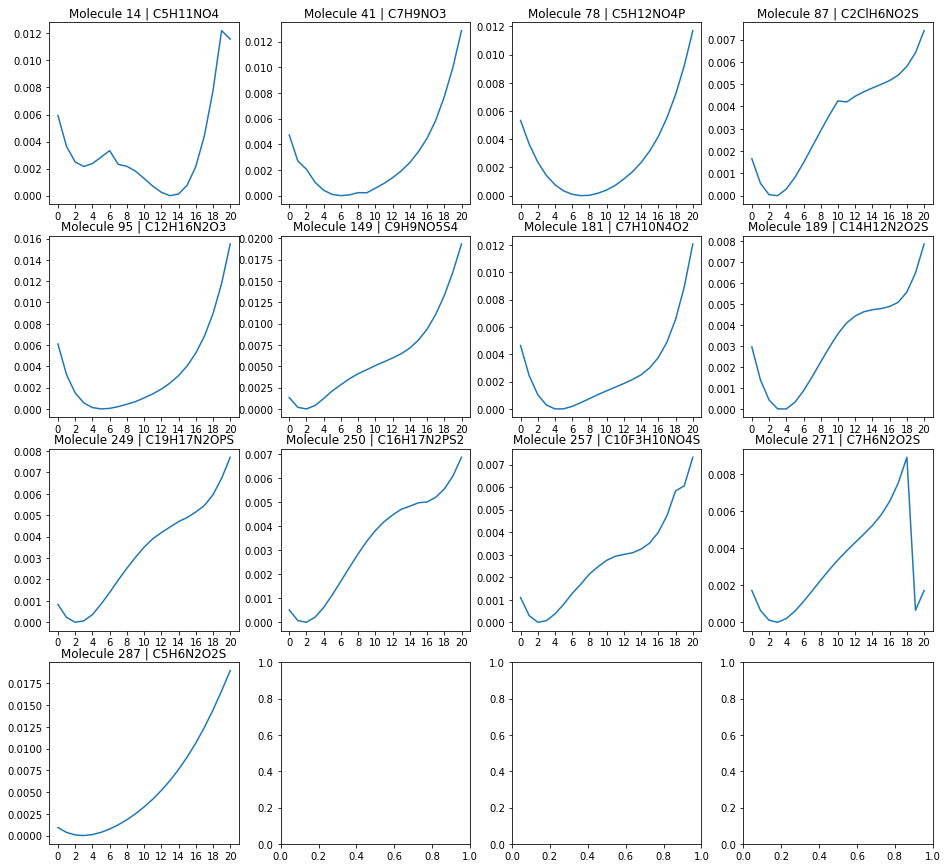

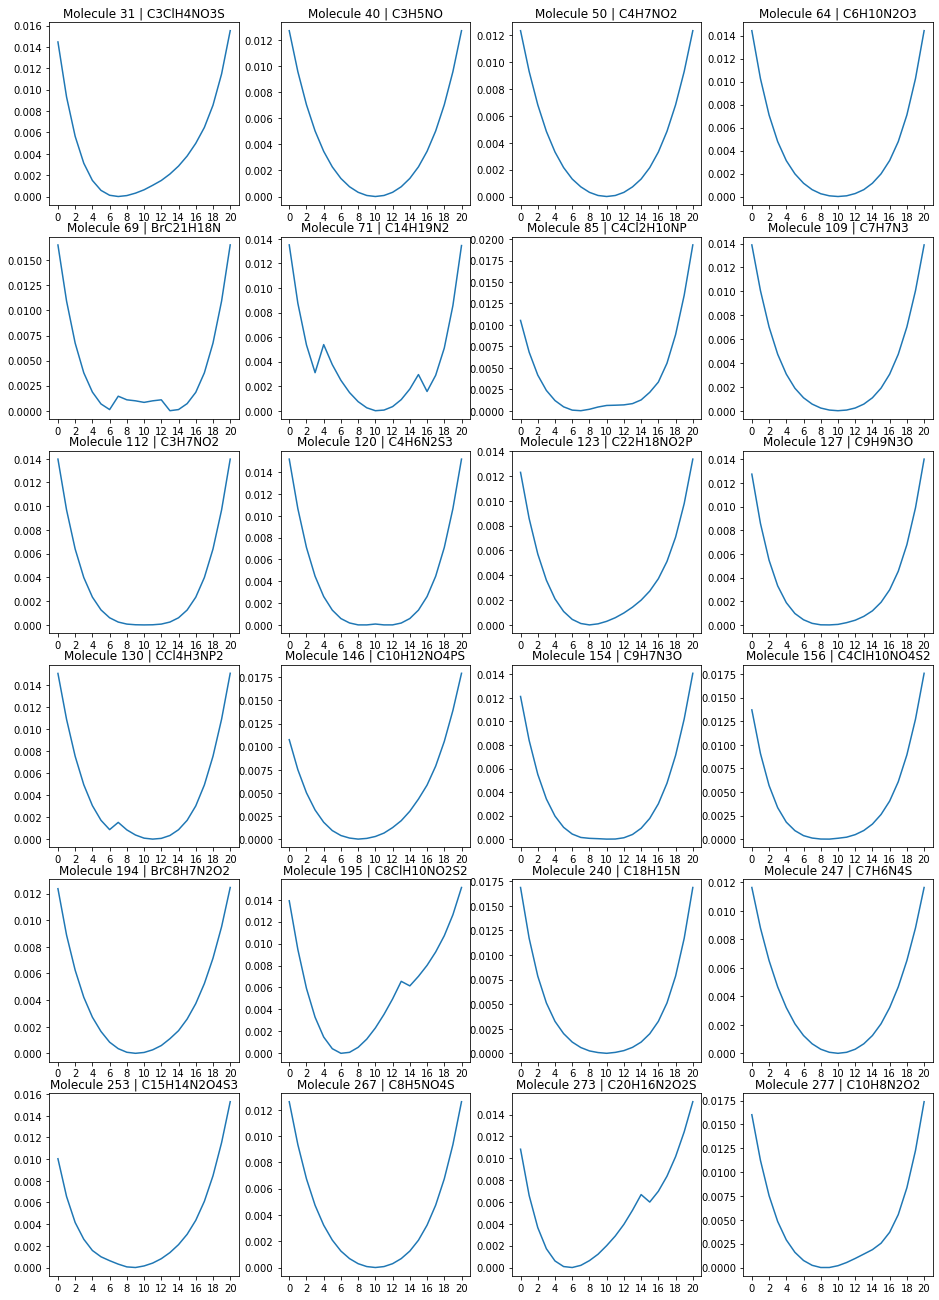

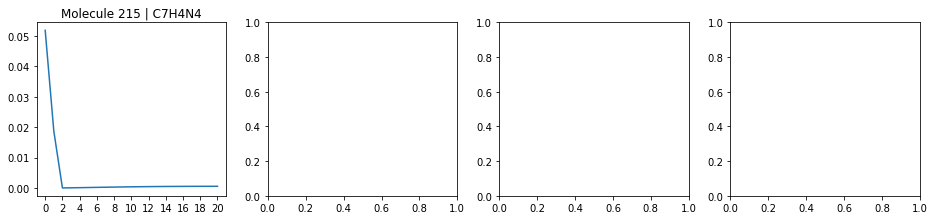

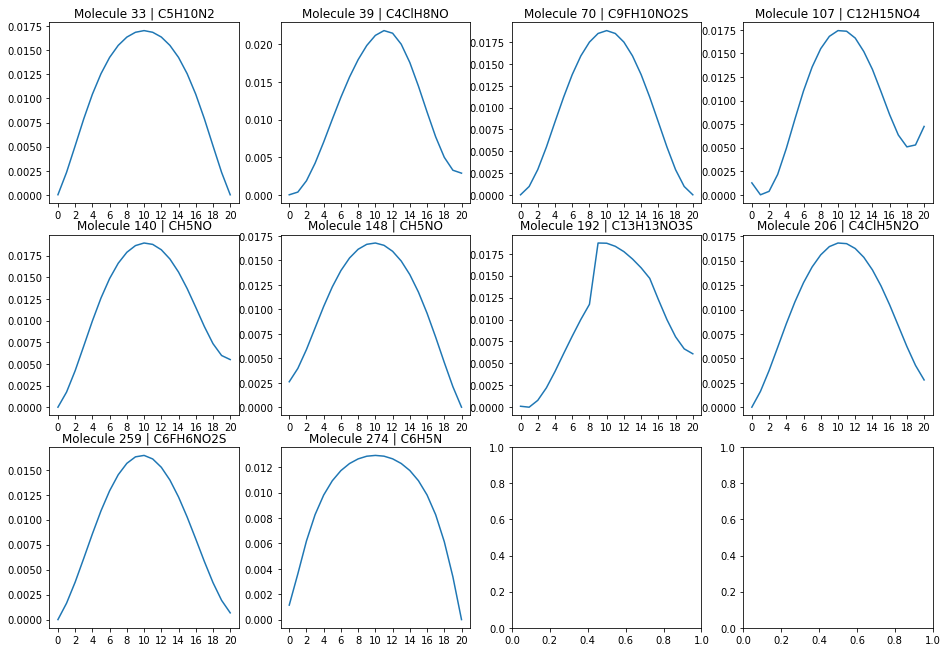

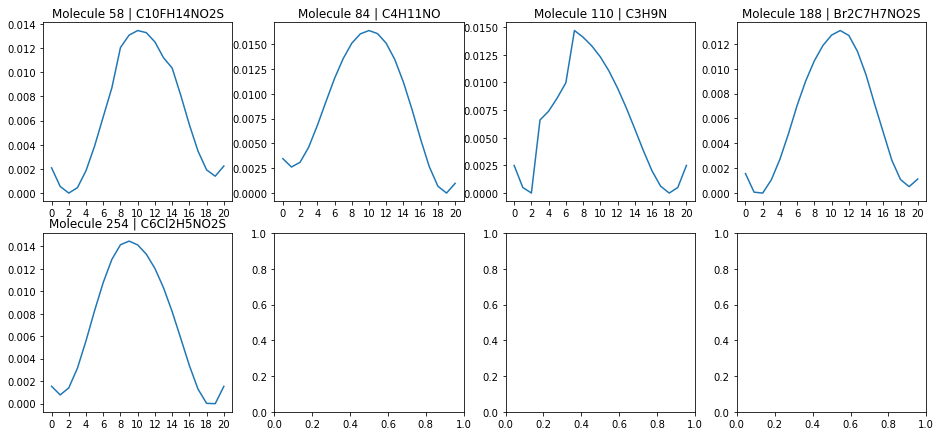

In [92]:
plot_details_for_clusters(clusters)